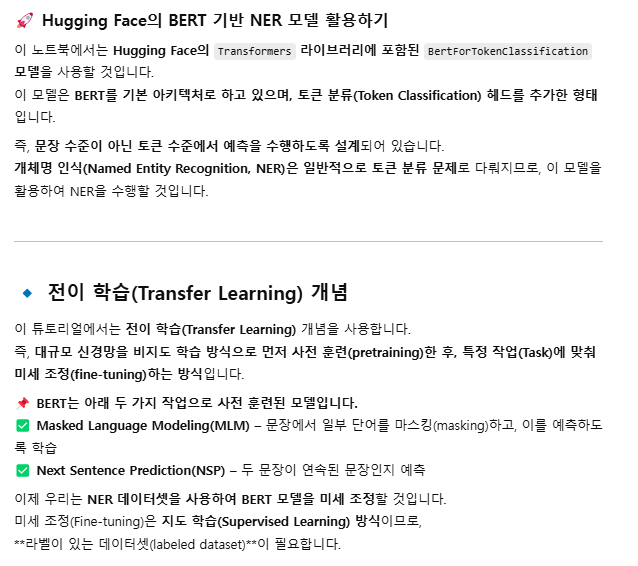

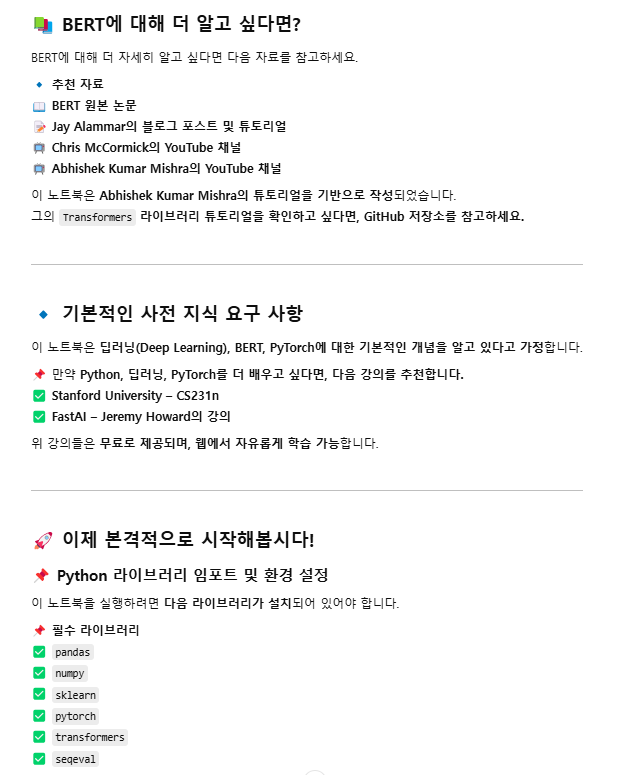

In [ ]:
!pip install transformers seqeval[gpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=ce7283644aac4ee3b92b9044403b1cc7d89573de8f2c466843c1574e9001f843
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("namanj27/ner-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.17M/3.17M [00:00<00:00, 139MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/namanj27/ner-dataset/versions/2


In [ ]:
import shutil

# 원본 경로
src_path = "/root/.cache/kagglehub/datasets/namanj27/ner-dataset/versions/2"
# 이동할 경로
dest_path = "/content/ner-dataset"

# 디렉터리 이동
shutil.move(src_path, dest_path)

print(f"Dataset moved to {dest_path}")


Dataset moved to /content/ner-dataset


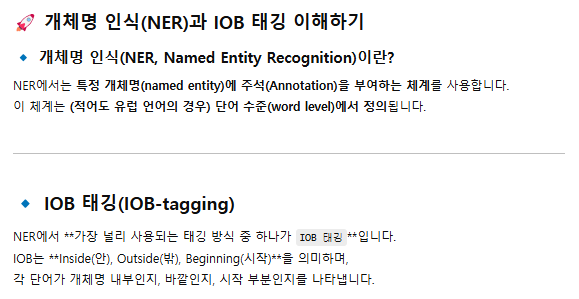

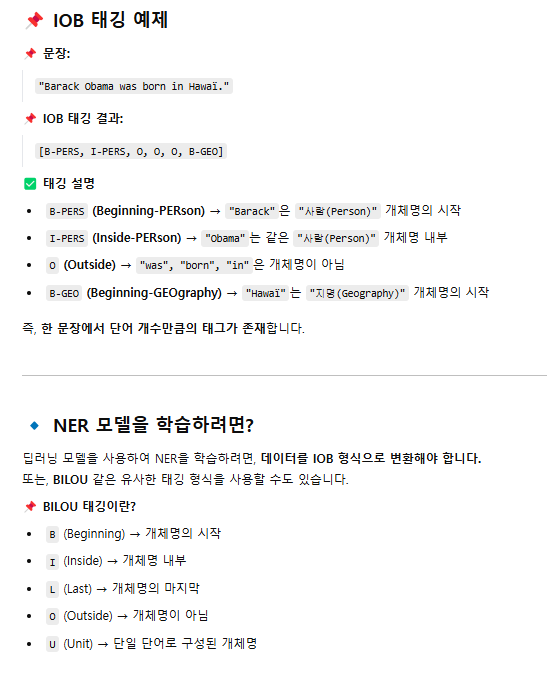

In [ ]:
##################### bert 기반의 ner 모델 사용을 위해 spacy의 함수 사용
데이터(it기술사전 문자 단위)를 iob 형식으로 변환

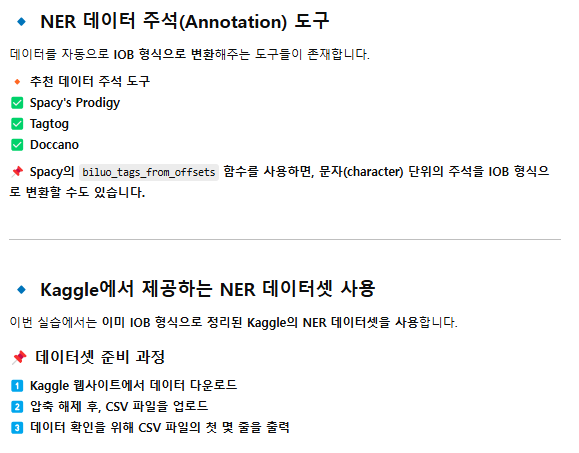

In [ ]:
data = pd.read_csv("/content/ner-dataset/ner_datasetreference.csv", encoding='unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
Let's check how many sentences and words (and corresponding tags) there are in this dataset:
# 데이터셋에서 문장과 단어 살펴본 결과

In [ ]:
data.count()

,0
Sentence #,47959
Word,1048565
POS,1048575
Tag,1048575


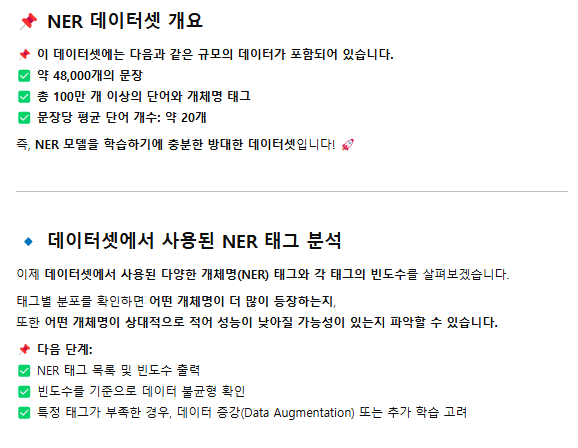

In [ ]:
데이터셋에는 약 48,000개의 문장이 포함되어 있으며,
총 100만 개 이상의 단어와 태그로 이루어져 있습니다. (꽤 방대한 데이터입니다!)
이는 문장당 약 20개의 단어가 포함되어 있음을 의미합니다.

이제 데이터셋에서 사용된 다양한 NER 태그와 그 빈도수를 살펴보겠습니다.

In [ ]:
print("Number of tags: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
frequencies

Number of tags: 17


,count
Tag,
O,887908
B-geo,37644
B-tim,20333
B-org,20143
I-per,17251
B-per,16990
I-org,16784
B-gpe,15870
I-geo,7414


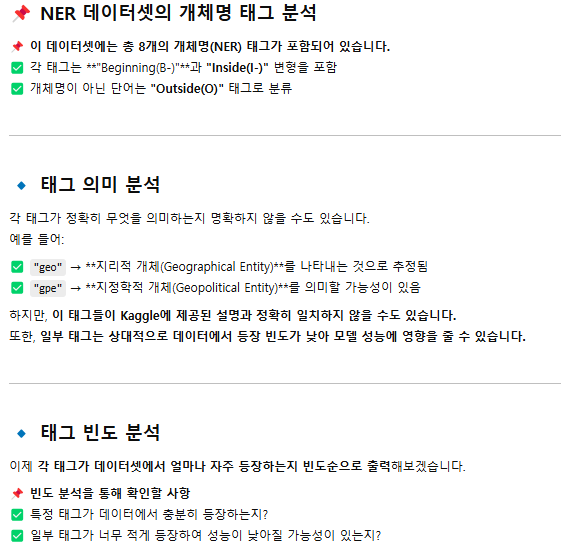

In [ ]:
데이터셋에는 총 8개의 개체명(NER) 태그가 있으며,
각 태그는 **"Beginning(B-)"**과 "Inside(I-)" 변형을 포함하고 있습니다.
또한, 개체명이 아닌 단어를 위한 "Outside(O)" 태그도 존재합니다.

그러나 각 태그가 정확히 무엇을 의미하는지 명확하지 않습니다.
예를 들어:

"geo"는 **지리적 개체(geographical entity)**를 의미하는 것으로 보입니다.
"gpe"는 **지정학적 개체(geopolitical entity)**를 나타내는 것 같습니다.
하지만, 이 태그들은 Kaggle에 제공된 설명과 완전히 일치하지 않습니다.
일부 태그는 상대적으로 데이터에서 비중이 적게 등장하는 것으로 보입니다.

이제 각 태그가 데이터셋에서 얼마나 자주 등장하는지 빈도순으로 출력해보겠습니다! 🚀

In [ ]:
tags = {}
for tag, count in zip(frequencies.index, frequencies):
    if tag != "O":
        if tag[2:5] not in tags.keys():
            tags[tag[2:5]] = count
        else:
            tags[tag[2:5]] += count
    continue

print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

[('geo', 45058), ('org', 36927), ('per', 34241), ('tim', 26861), ('gpe', 16068), ('art', 699), ('eve', 561), ('nat', 252)]


In [ ]:
"art", "eve", "nat" 개체명(named entity)들은 데이터에서 등장 빈도가 낮거나
다른 개체명과 비교했을 때 성능이 낮을 가능성이 높습니다.

따라서, 이 개체명들은 제거하여 모델의 성능을 더 안정적으로 유지하도록 하겠습니다.

In [ ]:
entities_to_remove = ["B-art", "I-art", "B-eve", "I-eve", "B-nat", "I-nat"]
data = data[~data.Tag.isin(entities_to_remove)]
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


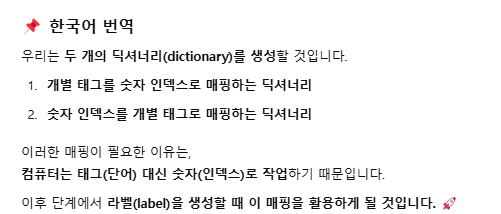

In [ ]:
labels_to_ids = {k: v for v, k in enumerate(data.Tag.unique())}
ids_to_labels = {v: k for v, k in enumerate(data.Tag.unique())}
labels_to_ids

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'I-per': 8,
 'I-gpe': 9,
 'I-tim': 10}

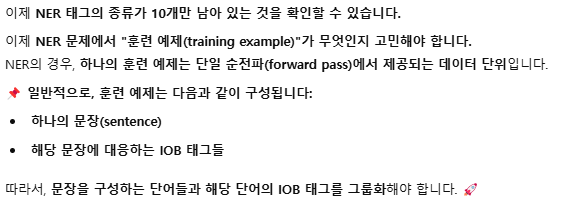

In [ ]:
# pandas has a very handy "forward fill" function to fill missing values based on the last upper non-nan value
data = data.fillna(method='ffill')
data.head()

<ipython-input-14-22549ca49efa>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
# let's create a new column called "sentence" which groups the words by sentence
data['sentence'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence
data['word_labels'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))
data.head()

,Sentence #,Word,POS,Tag,sentence,word_labels
0,Sentence: 1,Thousands,NNS,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Sentence: 1,of,IN,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
2,Sentence: 1,demonstrators,NNS,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
3,Sentence: 1,have,VBP,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
4,Sentence: 1,marched,VBN,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."


In [ ]:
# 중복을 제거한 문장과 단어 라벨 컬럼만 유지

In [ ]:
data = data[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data.head()

,sentence,word_labels
0,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,..."
2,They marched from the Houses of Parliament to ...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,I-geo,O"
3,"Police put the number of marchers at 10,000 wh...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,The protest comes on the eve of the annual con...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,B-org,I-org,O,..."


In [ ]:
len(data)

47571

In [ ]:
data.iloc[41].sentence

'Bedfordshire police said Tuesday that Omar Khayam was arrested in Bedford for breaching the conditions of his parole .'

In [ ]:
data.iloc[41].word_labels

'B-gpe,O,O,B-tim,O,B-per,I-per,O,O,O,B-geo,O,O,O,O,O,O,O,O'

In [ ]:
# 데이터셋과 데이터로더 준비하기

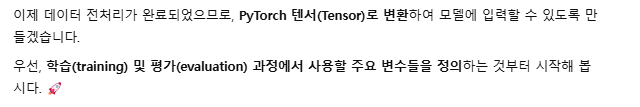

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

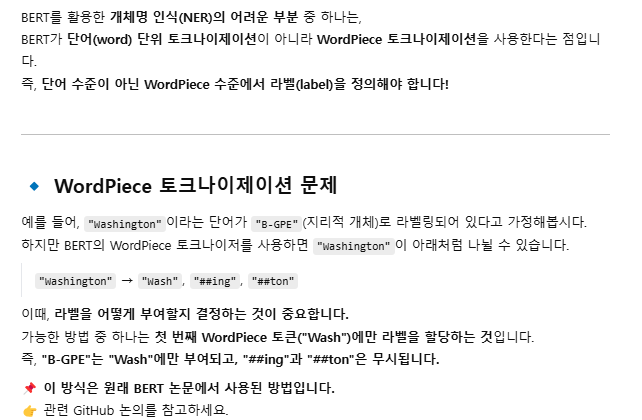

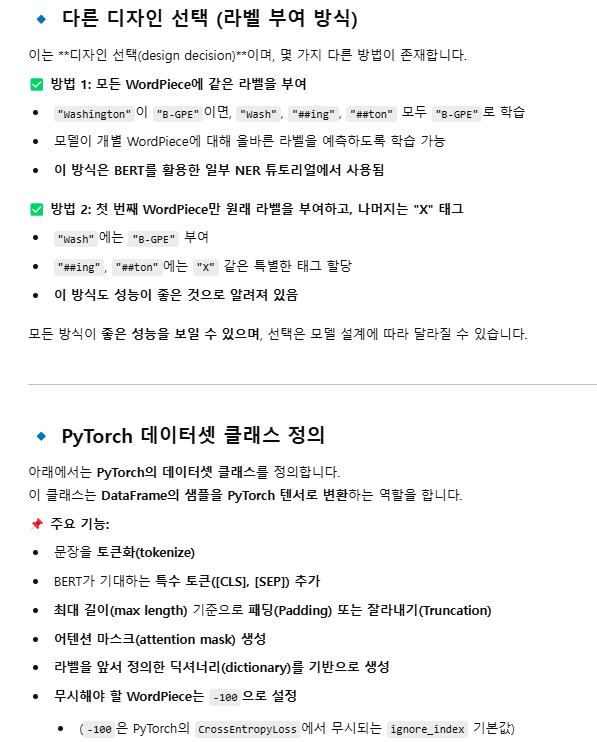

In [ ]:
# 최가윤 생각
방법 1이 낫다 : 모든 워드조각 단위에 같은 라벨을 부여한다.
그래야 it 기술 용어 중에 공백이 있어도 같은 라벨을 부여해서 동의어 간주 작업이 수월해지기 때문이다.


In [ ]:
# 라벨을 딕셔너리 기반으로 생성하는 것이 관건이다.

In [ ]:
파이토치의 dataset 클래스로 ner 데이터셋으로 변환
1) 데이터프레임에서 데이터를 가져오기
2) 모델에 입력할 수 있도록 토크나이징과 라벨 변환 수행

dataset 클래스는 dataloader와 함께 사용, 배치 단위로 데이터 불러올 때 활용

# 요약
문장과 라벨을 가져와서 버트의 토크나이저로 wordpiece 단위로 각각 변환하여 파이토치 텐서로 사용한다.

In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index].strip().split()
        word_labels = self.data.word_labels[index].split(",")

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_pretokenized=True,
                             return_offsets_mapping=True,
                             padding='max_length',
                             truncation=True,
                             max_length=self.max_len)

        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels]
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100

        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item

  def __len__(self):
        return self.len

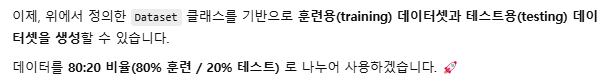

In [ ]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (47571, 2)
TRAIN Dataset: (38057, 2)
TEST Dataset: (9514, 2)


In [ ]:
training_set[0]

{'input_ids': tensor([  101, 23564, 21030,  2099,  4967,  2001,  9388,  1011,  6109,  2005,
          2634,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [ ]:
# 더이상 is_pretokenized 함수를 지원 x

In [ ]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # Step 1: 문장과 라벨 가져오기
        sentence = self.data.sentence[index].strip().split()
        word_labels = self.data.word_labels[index].split(",")

        # Step 2: BERT 토크나이저로 변환
        encoding = self.tokenizer(
            sentence,
            is_split_into_words=True,  # ✅ 변경됨
            return_offsets_mapping=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_len
        )

        # Step 3: WordPiece에 맞게 라벨 변환
        labels = [labels_to_ids[label] for label in word_labels]
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100

        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
            if mapping[0] == 0 and mapping[1] != 0:
                encoded_labels[idx] = labels[i]
                i += 1

        # Step 4: PyTorch 텐서로 변환
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item

    def __len__(self):
        return self.len


In [ ]:
# 토큰과 라벨 확인
현재 BERT 토큰화된 문장과 라벨(개체명 태그)이 올바르게 매핑되었는지 확인하는 과정

In [ ]:
# cls sep 토큰
[CLS](문장 시작) 및 [SEP](문장 종료)는 BERT에서 자동 추가하는 특수 토큰
이들은 라벨이 필요하지 않으므로 -100으로 설정됨 (PyTorch CrossEntropyLoss에서 무시됨 ✅)

In [ ]:
✅ WordPiece 토큰화가 정상적으로 적용됨 (B- 태그는 첫 WordPiece에만 부여)
✅ 개체명(B-GEO, B-PER 등)이 적절히 매핑됨
✅ O(일반 단어) 라벨이 적용됨

In [ ]:
# 기타 pad 토큰
패딩 토큰은 -100으로 설정됨 → 학습에서 무시됨 ✅


In [ ]:
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["input_ids"]), training_set[0]["labels"]):
  print('{0:10}  {1}'.format(token, label))

[CLS]       -100
za          3
##hee       -100
##r         -100
khan        8
was         0
mar         0
-           -100
93          -100
for         0
india       1
.           0
[SEP]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[

In [ ]:
# 학습 데이터 불러오기
이제 NER 데이터셋을 PyTorch 모델에 학습시킬 수 있도록 DataLoader를 정의할 거야.
DataLoader는 배치(batch) 단위로 데이터를 불러오고, 모델 학습을 효율적으로 수행하는 데 도움을 줘.

In [ ]:
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,  # 훈련 데이터 배치 크기
    'shuffle': True,  # 데이터를 랜덤하게 섞음 (훈련 시 필수)
    'num_workers': 0  # 데이터 로딩 병렬 처리 (Google Colab에서는 0이 권장됨)
}

test_params = {
    'batch_size': VALID_BATCH_SIZE,  # 검증 데이터 배치 크기
    'shuffle': True,  # 테스트 데이터도 섞어서 로딩 (보통 False로 설정하는 경우도 있음)
    'num_workers': 0  # Google Colab에서는 0이 안전
}


training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
batch_size → 한 번에 학습할 샘플 개수 (너무 크면 GPU 메모리 부족 가능)
shuffle=True → 데이터를 랜덤하게 섞어서 모델이 더 일반화되도록 함 (훈련 데이터에 필요)
num_workers=0 → 데이터 로딩의 병렬 처리 개수 (Colab에서는 0이 안정적)

모델 정의하기

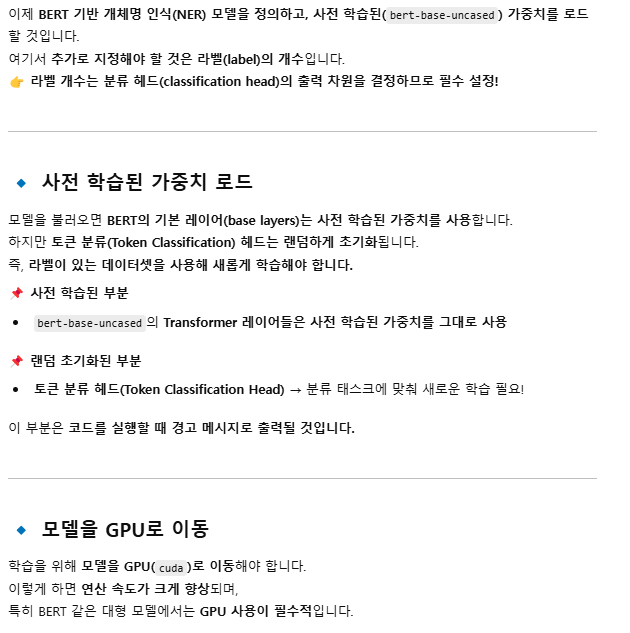

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

# 모델 훈련하기

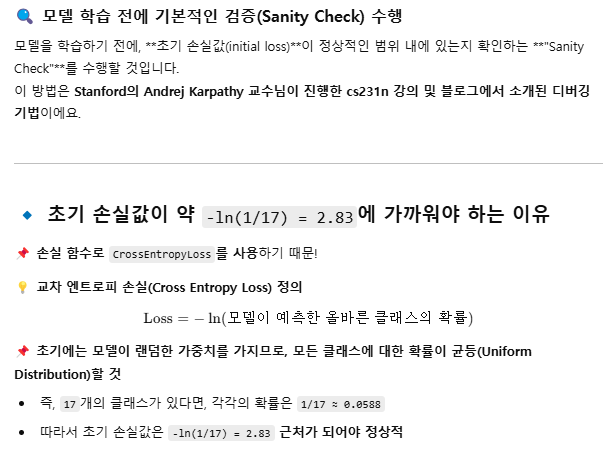

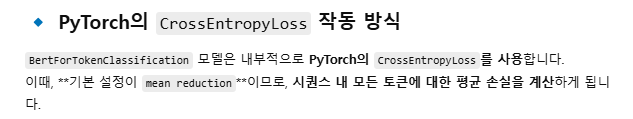

In [ ]:
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(2.5343, grad_fn=<NllLossBackward0>)

In [ ]:
초기 손실값이 정상적으로 계산되었음을 확인했으므로, 이제 모델의 출력(logits) 차원을 검증해 보겠습니다.

In [ ]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 11])

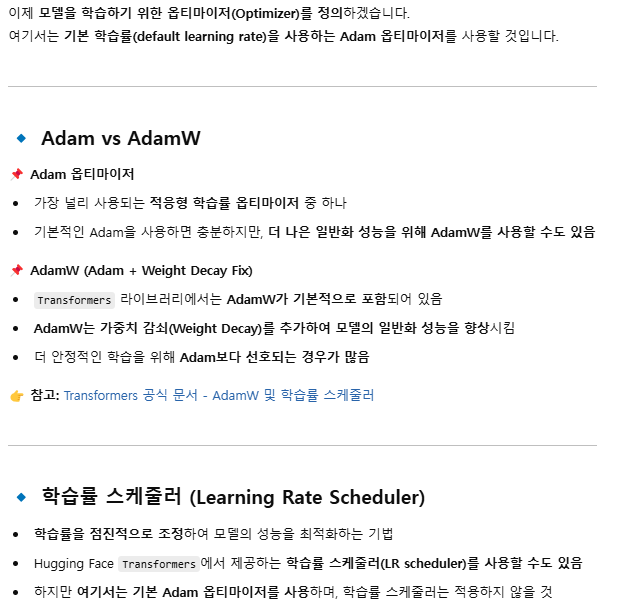

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
이제 일반적인 PyTorch 학습 함수(training function)를 정의하겠습니다.
이 함수는 멀티링구얼 NER(Multilingual Named Entity Recognition) 관련 우수한 리포지토리를 참고하여 일부 구성되었습니다.

📌 참고: Multilingual NER GitHub Repository

In [ ]:
https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L344

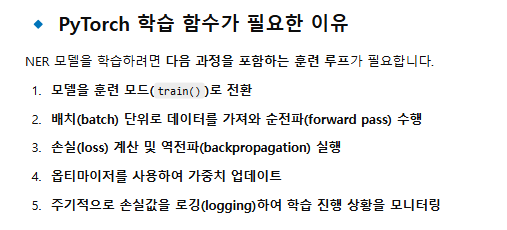

In [ ]:
이 코드는 BERT 기반의 NER 모델을 학습하는 PyTorch train() 함수야.
훈련 데이터셋(80%)을 사용하여 BERT 모델을 튜닝(fine-tuning)하는 과정이 포함되어 있어.



In [ ]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch): # 현재 학습 에포크(반복 횟수)
    tr_loss, tr_accuracy = 0, 0 # 학습 손실 및 정확도 초기화
    nb_tr_examples, nb_tr_steps = 0, 0 # 학습 샘플 개수 및 스텝 개수
    tr_preds, tr_labels = [], [] # 예측값과 실제 라벨을 저장할 리스트
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader): # training_loader에서 배치를 하나씩 가져옴
        # 각 배치는 input_ids, attention_mask, labels로 구성됨
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
# 모델 훈련하기
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1


AttributeError: 'str' object has no attribute 'item'

# 모델 평가하기

In [ ]:
# valid 함수

이제 모델 학습을 완료했으므로, 테스트 데이터셋(전체의 20%)에서 성능을 평가할 것입니다.
테스트 과정에서는 모델의 가중치를 업데이트하지 않으며,
단순히 로짓(logits)을 출력하여 성능을 확인합니다.


In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0 # 검증 손실과 정확도 저장 변수
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], [] # 예측값, 실제 라벨 값 저장 리스트

    with torch.no_grad(): # 메모리 절약, 성능 최적화
        for idx, batch in enumerate(testing_loader): # testing_loader에서 배치 단위로 로드

            # bert의 입력은 long 타입이여야 한다.
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            # 순전파 수행  # model 함수로 손실과 예측값 반환
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            eval_loss += loss.item() # 손실값 저장

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)

            # 손실값 모니터링
            # 100번째 배치마다 검증 손실 출력 → 학습 모니터링 가능
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy - 평가 정확도 계산
            # 라벨(labels)과 예측값(eval_logits)을 벡터 형태로 변환
            # torch.argmax()를 사용하여 가장 높은 확률을 가진 클래스를 예측값으로 변환
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

            # only compute accuracy at active labels - 유효한 라벨만 선택
            # 라벨이 -100이 아닌(실제 데이터가 있는) 부분만 평가에 포함
            # masked_select()를 사용하여 유효한 부분만 선택

            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            # 예측값과 정확도 저장
            # accuracy_score()를 이용하여 배치별 정확도 계산 후 누적
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    # 예측값을 실제 라벨로 변환
    # 숫자로 표현된 라벨을 원래의 ner로 변환
    # ids_to_labels 딕셔너리를 사용하여 정수 ID를 원래 라벨로 변환
    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]

    # 최종 검증 손실 및 정확도 출력
    # 평균 손실값(eval_loss)과 정확도(eval_accuracy)를 출력
    # 최종 예측된 라벨 및 정답 반환
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
성능이 꽤나 좋다, 정확도가 93%이상이기 때문이다.
Validation Loss: 0.11292897437864133
Validation Accuracy: 0.9655877804714731

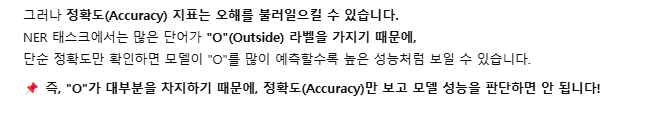

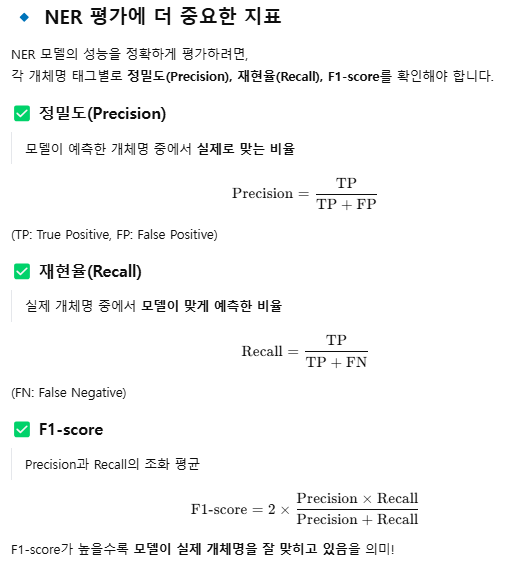

In [ ]:
labels, predictions = valid(model, testing_loader)

AttributeError: 'str' object has no attribute 'item'

In [ ]:
!pip install seqeval


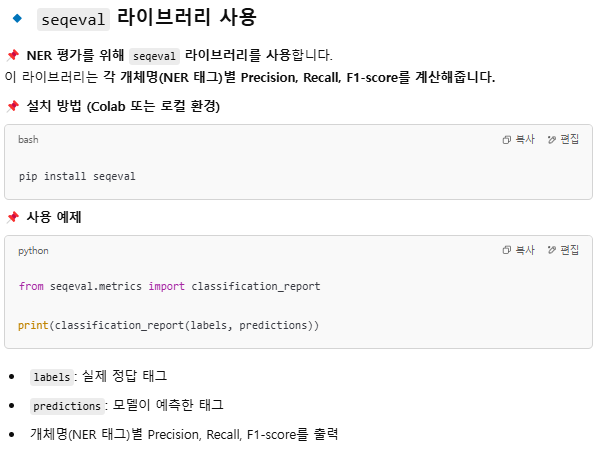

In [ ]:
from seqeval.metrics import classification_report

print(classification_report(labels, predictions))

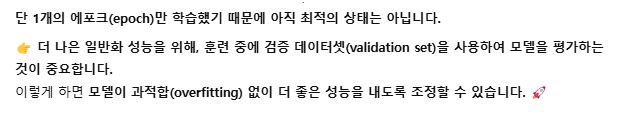

# 추론하기 inference

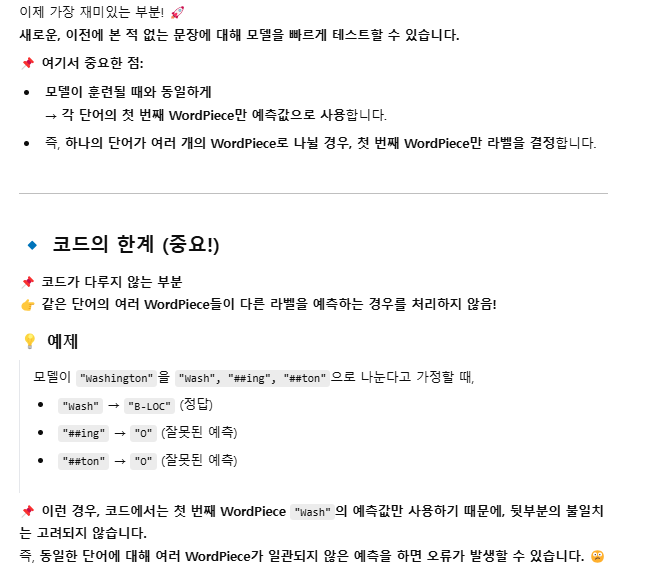

In [ ]:
# 새로운 문장에 대해 ner 예측 수행

In [ ]:
sentence = "@HuggingFace is a company based in New York, but is also has employees working in Paris"

# 문장을 버트 토크나이저로 전처리
inputs = tokenizer(sentence.split(),
                    is_pretokenized=True,
                    return_offsets_mapping=True,
                    padding='max_length',
                    truncation=True,
                    max_length=MAX_LEN,
                    return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)

# forward pass - 모델에 입력을 넣어주고 전방 패스 실행
outputs = model(ids, attention_mask=mask)
logits = outputs[0]

# 예측 로짓을 개체명 태그로 변환
active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

# 원래 토큰과 예측된 개체명 태그를 매핑
tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [ids_to_labels[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

# 첫 번째 wordpiece만 예측값으로 사용
# offset_mapping을 사용하여 각 WordPiece가 원래 문장의 어디에 해당하는지 확인
# 첫 번째 WordPiece(mapping[0] == 0)에 대해서만 개체명 태그를 사용
# 이후 WordPiece들은 무시 (훈련 데이터 처리 방식과 일관성 유지)
prediction = []
for token_pred, mapping in zip(wp_preds, inputs["offset_mapping"].squeeze().tolist()):
  #only predictions on first word pieces are important
  if mapping[0] == 0 and mapping[1] != 0:
    prediction.append(token_pred[1])
  else:
    continue

print(sentence.split())
print(prediction)

# 향후 사용을 위해, 모델 저장하기

In [ ]:
import os

directory = "./model" # 모델과 토크나이저를 저장할 폴더 설정

if not os.path.exists(directory): # 폴더가 존재하는지 확인
    os.makedirs(directory) # 없으면 하나 생성

# save vocabulary of the tokenizer - 토크나이저 저장
# BERT 토크나이저의 단어 사전(vocab.txt)을 ./model/ 폴더에 저장
tokenizer.save_vocabulary(directory)

# save the model weights and its configuration file
# 모델의 가중치(Weights)와 설정(Configuration)를 저장
# 저장되는 파일
# ./model/pytorch_model.bin → 모델 가중치
# ./model/config.json → 모델 설정 파일

model.save_pretrained(directory)
print('All files saved')
print('This tutorial is completed')

In [ ]:
# 위에 저장한 모델과 가중치를 다시 불러오려면 아래 코드 수행
from transformers import BertForTokenClassification, BertTokenizer

# 저장된 모델과 토크나이저 불러오기
model = BertForTokenClassification.from_pretrained("./model")
tokenizer = BertTokenizer.from_pretrained("./model")

print("Model and tokenizer loaded successfully!")


# 우리 프로젝트에서 사용하는 기술 사전과 형태소 내용 확인하기

In [1]:
import pandas as pd

# CSV 파일 로드
df = pd.read_csv("technical_element.csv", encoding="utf-8-sig")
df

,seq,category,name,synonym
0,0,language,solidity,solidity
1,1,language,c,c
2,2,language,c++,c++
3,3,language,c#,c#
4,4,language,dart,dart
...,...,...,...,...
273,273,tool,dask,dask
274,274,tool,openstack,openstack
275,275,tool,terraform,terraform
276,276,tool,zeplin,zeplin


In [1]:
!pip install --upgrade transformers[torch]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 116.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [2]:
!pip install datasets seqeval torch scikit-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.1 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=8482694a834007aab98ab0b122c6fd355ba444fe1387a1d0ddcb10d4fc95dcea
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency 

In [ ]:
# bert ner 학습(자체 ner 태깅작업한 데이터 - 4가지 기술 ner 사전 )

In [4]:

# 데이터 경로 설정
NER_TRAIN_DATA = "/content/ner_labeled_data.csv"


In [5]:
# 허깅페이스 라이브러리 불러오기
import pandas as pd
import torch
from transformers import BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments
from datasets import Dataset
from seqeval.metrics import classification_report


In [6]:
# ner 데이터 로드 및 전처리
df = pd.read_csv(NER_TRAIN_DATA, encoding="utf-8-sig")

model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# NER 태그 정의
ner_labels = ["O", "B-LANG", "I-LANG", "B-FRAME", "I-FRAME", "B-LIB", "I-LIB", "B-TOOL", "I-TOOL"]
label_map = {label: idx for idx, label in enumerate(ner_labels)}

# 데이터 전처리 함수
def preprocess_data(examples):
    tokens = examples["wordpiece_tokens"].split()
    labels = examples["ner_labels"].split()

    # ✅ 길이 맞추기 위해 `padding=True, truncation=True` 추가
    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        truncation=True,  # 긴 문장 잘라내기
        padding="max_length",  # 짧은 문장은 패딩 추가
        max_length=128  # 최대 길이 설정 (BERT 기본값)
    )

    # ✅ 라벨 길이도 128에 맞추기
    label_ids = [label_map.get(label, label_map["O"]) for label in labels]
    label_ids += [label_map["O"]] * (128 - len(label_ids))  # 패딩

    inputs["labels"] = label_ids
    return inputs

dataset = Dataset.from_pandas(df)
dataset = dataset.map(preprocess_data)

# 훈련 & 평가 데이터 분할
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset, eval_dataset = train_test_split["train"], train_test_split["test"]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Map:   0%|          | 0/3930 [00:00<?, ? examples/s]

In [7]:
def predict_ner(text):
    tokens = tokenizer.tokenize(text)
    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,  # 긴 문장 자르기
        padding="max_length",  # 짧은 문장은 패딩
        max_length=128
    )

    with torch.no_grad():
        outputs = model(**inputs)

    predictions = torch.argmax(outputs.logits, dim=2)
    predicted_labels = [ner_labels[idx.item()] for idx in predictions[0]]

    return tokens, predicted_labels

In [ ]:
# 나의 wandb api 키
# 최가윤 wandb api키
66fe5c30f4a5c3d836a6fe750793e814e45acd0d


In [ ]:
# tokenizer가 변환한 텐서들의 길이가 동일하지 않아 BERT 모델에 입력할 수 없음.
해결하려면 모든 입력을 동일한 길이로 맞추기 위해 padding=True, truncation=True 옵션 추가해야 함.

In [8]:
# bert 모델 학습(파인튜닝)
training_args = TrainingArguments(
    output_dir="./ner_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    report_to="wandb",  # ✅ wandb 사용 설정
    run_name="BERT-NER-Experiment"  # ✅ 명시적 `run_name` 설정 (경고 해결)
)


model = BertForTokenClassification.from_pretrained(model_name, num_labels=len(ner_labels))

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

trainer.train()

# 모델 저장
model.save_pretrained("/content/ner_model")
tokenizer.save_pretrained("/content/ner_model")


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-8-afdc5668cb62>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cgygy8989 (cgygy8989-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`labels` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

In [ ]:
# 실제 데이터를 이용한 자동 분류, 모델 성능 평가

In [9]:
model_path = "/content/ner_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForTokenClassification.from_pretrained(model_path)
model.eval()


OSError: Can't load tokenizer for '/content/ner_model'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure '/content/ner_model' is the correct path to a directory containing all relevant files for a BertTokenizer tokenizer.

In [ ]:
# 실제 외래어 토큰만 남긴 데이터 올리기

In [ ]:
FOREIGN_WORDS_DATA = "/content/filtered_foreign_words.csv"

# 데이터 불러오기
foreign_df = pd.read_csv(FOREIGN_WORDS_DATA, encoding="utf-8-sig")

# 예측 함수 정의
def predict_ner(text):
    tokens = tokenizer.tokenize(text)
    inputs = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        outputs = model(**inputs)

    predictions = torch.argmax(outputs.logits, dim=2)  # 가장 높은 확률값 선택
    predicted_labels = [ner_labels[idx.item()] for idx in predictions[0]]

    return tokens, predicted_labels

# 모든 행에 대해 NER 예측 수행
foreign_df["tokens"], foreign_df["predicted_labels"] = zip(*foreign_df["foreign_only"].apply(predict_ner))

# 결과 저장
foreign_df.to_csv("/content/predicted_ner_results.csv", index=False, encoding="utf-8-sig")


In [ ]:
# 모델 성능 평가
자동 분류된 데이터 분석
 정확하게 4가지 기술 (B-LANG, B-FRAME, B-LIB, B-TOOL)로 잘 분류되는지 확인.

In [ ]:
predicted_df = pd.read_csv("/content/predicted_ner_results.csv", encoding="utf-8-sig")

# NER 태그별 개수 확인
category_counts = predicted_df["predicted_labels"].explode().value_counts()
print(category_counts)


다시 작업해보기

In [10]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments
from datasets import Dataset
from seqeval.metrics import classification_report

# 🔹 NER 데이터 경로 설정 (Google Drive에서 가져오기)
NER_TRAIN_DATA = "/content/ner_labeled_data.csv"

# 🔹 데이터 불러오기
df = pd.read_csv(NER_TRAIN_DATA, encoding="utf-8-sig")

# 🔹 Hugging Face 사전 학습 모델 불러오기
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# 🔹 NER 태그 정의
ner_labels = ["O", "B-LANG", "I-LANG", "B-FRAME", "I-FRAME", "B-LIB", "I-LIB", "B-TOOL", "I-TOOL"]
label_map = {label: idx for idx, label in enumerate(ner_labels)}

# 🔹 데이터 전처리 함수 (토큰화 + NER 라벨 인코딩)
def preprocess_data(examples):
    tokens = examples["wordpiece_tokens"].split()
    labels = examples["ner_labels"].split()

    # ✅ 토큰화를 실행하고 padding & truncation 적용
    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=512
    )

    # ✅ 실제 토큰 길이 가져오기
    input_length = len(inputs["input_ids"])

    # ✅ labels의 길이를 input_ids와 동일하도록 설정
    label_ids = [label_map.get(label, label_map["O"]) for label in labels]
    label_ids += [label_map["O"]] * (input_length - len(label_ids))
    label_ids = label_ids[:input_length]  # 최대 input_length까지만 유지

    # ✅ inputs에 labels 추가
    inputs["labels"] = label_ids

    return inputs

# 🔹 Hugging Face Dataset 변환
dataset = Dataset.from_pandas(df)
dataset = dataset.map(preprocess_data)

# 🔹 훈련 & 평가 데이터 분할
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset, eval_dataset = train_test_split["train"], train_test_split["test"]


Map:   0%|          | 0/3930 [00:00<?, ? examples/s]

In [11]:
# ✅ 문장의 최대 길이 확인
df["token_length"] = df["wordpiece_tokens"].apply(lambda x: len(x.split()))
print(df["token_length"].describe())  # 최대 길이, 평균 길이 확인


count    3930.000000
mean       46.958524
std        58.887411
min         1.000000
25%        21.000000
50%        34.000000
75%        53.750000
max       843.000000
Name: token_length, dtype: float64


# 2.11 성공 코드 - 다시 수행해보기

In [12]:
# 🔹 TrainingArguments 설정
training_args = TrainingArguments(
    output_dir="./ner_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,  # ✅ 배치 크기 줄이기
    per_device_eval_batch_size=4,  # ✅ 배치 크기 줄이기
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    report_to="wandb",
    run_name="BERT-NER-Experiment"
)

# 🔹 BERT 모델 초기화 (새로운 NER 태그 사용)
model = BertForTokenClassification.from_pretrained(model_name, num_labels=len(ner_labels))

# 🔹 Trainer 생성
from torch.utils.data import DataLoader
from transformers import DataCollatorForTokenClassification

# ✅ 데이터 콜레이터 생성 (자동 패딩 적용)
data_collator = DataCollatorForTokenClassification(tokenizer)

# ✅ Trainer 설정에서 `data_collator` 추가
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator  # ✅ 동적 패딩 적용
)

# ✅ Dataset을 PyTorch 텐서로 변환
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
eval_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# 🔹 Fine-tuning 시작
print("🚀 Fine-tuning 시작...")
trainer.train()

# 🔹 학습된 모델 저장 (Google Drive에 저장)
model.save_pretrained("/content/ner_model")
tokenizer.save_pretrained("/content/ner_model")
print("✅ Fine-tuning 완료! 학습된 모델이 저장되었습니다.")


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-ff43acbef596>:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Fine-tuning 시작...


Epoch,Training Loss,Validation Loss
1,0.000000,0.000026
2,0.000000,0.000012
3,0.000000,0.000009


✅ Fine-tuning 완료! 학습된 모델이 저장되었습니다.


In [13]:
# 🔹 저장된 모델 불러오기
model_path = "/content/ner_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForTokenClassification.from_pretrained(model_path)
model.eval()
print("✅ 모델 로드 완료!")


✅ 모델 로드 완료!


In [ ]:
# 🔹 실제 외래어 데이터 경로
FOREIGN_WORDS_DATA = "/content/filtered_foreign_words.csv"

# 🔹 데이터 불러오기
foreign_df = pd.read_csv(FOREIGN_WORDS_DATA, encoding="utf-8-sig")

# 🔹 NER 예측 함수
def predict_ner(text):
    tokens = tokenizer.tokenize(text)

    # ✅ 512개 이상이면 잘라내기
    if len(tokens) > 512:
        tokens = tokens[:512]

    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    )

    with torch.no_grad():
        outputs = model(**inputs)

    predictions = torch.argmax(outputs.logits, dim=2)
    predicted_labels = [ner_labels[idx.item()] for idx in predictions[0]]

    return tokens, predicted_labels


# 🔹 모든 행에 대해 NER 예측 수행
foreign_df["tokens"], foreign_df["predicted_labels"] = zip(*foreign_df["foreign_only"].apply(predict_ner))

# 🔹 예측 결과 저장
foreign_df.to_csv("/content/predicted_ner_results.csv", index=False, encoding="utf-8-sig")
print("✅ 예측 완료! 결과가 저장되었습니다.")


In [ ]:
# 🔹 자동 분류된 데이터 로드
predicted_df = pd.read_csv("/content/predicted_ner_results.csv", encoding="utf-8-sig")

# 🔹 NER 태그별 개수 확인
category_counts = predicted_df["predicted_labels"].explode().value_counts()
print("🔹 기술별 분류 개수:")
print(category_counts)
